# Showcases integrated gradients on CIFAR10 dataset

This tutorial demonstrates how to apply model interpretability algorithms from Captum library on a simple model and test samples from CIFAR dataset.

In this tutorial we build a simple model as described in:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Then we use attribution algorithms such as `IntegratedGradients`, `Saliency`, `DeepLift` and `NoiseTunnel` to attribute the label of the image to the input pixels and visualize it.
  
  **Note:** Before running this tutorial, please install the torchvision, and matplotlib packages.

In [ ]:
!pip install captum

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In the cell below we load test and train datasets, define image transformers and supported classification label classes.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


We define a classification network based on the architecture proposed in the following tutorial:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        # input dim: 32*32*3
        # after conv1: 28*28*6
        # after pool1: 14*14*6
        # after conv2: 10*10*16
        # after pool2: 5*5*16
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Trains `Net` model for a very small number of epochs. The training code snippet is copied from the tutorial mentioned above. 
In order to avoid training the model every time from scratch, we save a pretrained version of the model in `models` folder and load it from there. https://github.com/pytorch/captum/blob/master/tutorials/models/cifar_torchvision.pt

In [6]:
import os

USE_PRETRAINED_MODEL = True

if not os.path.isdir('/models'):
  os.mkdir('/models')

if USE_PRETRAINED_MODEL and os.path.isfile('/models/cifar_torchvision.pt'):
    print("Using existing trained model")
    net.load_state_dict(torch.load('/models/cifar_torchvision.pt'))
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), '/models/cifar_torchvision.pt')

Using existing trained model


In the cell below we load some images from the test dataset and perform predictions.

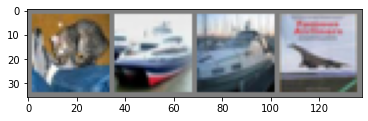

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane


In [7]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [8]:
print(outputs)
print(predicted)

tensor([[-5.1116, -4.9508,  5.6969,  7.1455,  0.6529,  4.1696,  3.4359, -1.6593,
         -3.7317, -4.4865],
        [ 5.5994,  8.6038, -4.2344, -4.6868, -3.2834, -5.8986, -4.9087, -3.1921,
          8.6197,  3.9456],
        [ 2.0119,  0.8491, -0.4865,  0.4970, -1.5228, -0.9074, -1.7042, -0.8516,
          1.6234,  1.2568],
        [ 2.8730,  0.2899,  0.4769, -1.0035,  0.1670, -1.3964, -1.1194, -1.0338,
          1.4236,  0.7617]], grad_fn=<AddmmBackward0>)
tensor([3, 8, 0, 0])


Let's choose a test image at index `ind` and apply some of our attribution algorithms on it.

In [9]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

Sets model to eval mode for interpretation purposes

In [10]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

A generic function that will be used for calling `attribute` on attribution algorithm defined in input.

In [11]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions
        

Computes gradients with respect to class `ind` and transposes them for visualization purposes.

In [12]:
# computes saliency map
saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

Applies integrated gradients attribution algorithm on test image. Integrated Gradients computes the integral of the gradients of the output prediction for the class index `ind` with respect to the input image pixels. More details about integrated gradients can be found in the original paper: https://arxiv.org/abs/1703.01365

In [13]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.1048], dtype=torch.float64)


Below we demonstrate how to use integrated gradients and noise tunnel with smoothgrad square option on the test image. Noise tunnel with `smoothgrad square` option adds gaussian noise with a standard deviation of `stdevs=0.2` to the input image `nt_samples` times, computes the attributions for `nt_samples` images and returns the mean of the squared attributions across `nt_samples` images.

In [14]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

Applies DeepLift on test image. Deeplift assigns attributions to each input pixel by looking at the differences of output and its reference in terms of the differences of the input from the reference.

In [15]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/usr/local/lib/python3.8/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In the cell below we will visualize the attributions for `Saliency Maps`, `DeepLift`, `Integrated Gradients` and `Integrated Gradients with SmoothGrad`.

In [ ]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")



# Implementing GradCAM
The code below is adapted from this tutorial https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

In [101]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # get the network
        self.convnet = net
        
        # disect the network to access its last convolutional layer
        self.features_conv = nn.Sequential(
                              self.convnet.conv1,
                              self.convnet.relu1,
                              self.convnet.pool1,
                              self.convnet.conv2,
                              self.convnet.relu2
                            )
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the model
        self.classifier = nn.Sequential(
                          self.convnet.fc1,
                          self.convnet.relu3,
                          self.convnet.fc2,
                          self.convnet.relu4,
                          self.convnet.fc3
                        )
                      
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [102]:
# initialize the model
convnet = ConvNet()

# set the evaluation mode
convnet.eval()

# get the image from the dataloader
dataiter = iter(testloader)
img, label = next(dataiter)

# get the most likely prediction of the model
output = convnet(img)
print(output)
print(output.shape)
_, pred = torch.max(output, 1)
print(pred)
print('Predicted: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

tensor([[-5.1116, -4.9508,  5.6969,  7.1455,  0.6529,  4.1696,  3.4359, -1.6593,
         -3.7317, -4.4865],
        [ 5.5994,  8.6038, -4.2344, -4.6868, -3.2834, -5.8986, -4.9087, -3.1921,
          8.6197,  3.9456],
        [ 2.0119,  0.8491, -0.4865,  0.4970, -1.5228, -0.9074, -1.7042, -0.8516,
          1.6234,  1.2568],
        [ 2.8730,  0.2899,  0.4769, -1.0035,  0.1670, -1.3964, -1.1194, -1.0338,
          1.4236,  0.7617]], grad_fn=<AddmmBackward0>)
torch.Size([4, 10])
tensor([3, 8, 0, 0])
Predicted:    cat  ship plane plane


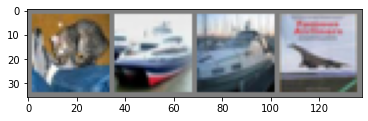

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane


In [82]:
imshow(torchvision.utils.make_grid(img))
print('GroundTruth: ', ' '.join('%5s' % classes[label[j]] for j in range(4)))

outputs = net(img)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [103]:
# index of the sample in the batch
sample_ind = 3

# get the gradient of the output with respect to the parameters of the model
torch.max(output[sample_ind]).backward()

# pull the gradients out of the model
gradients = convnet.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = convnet.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(16):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

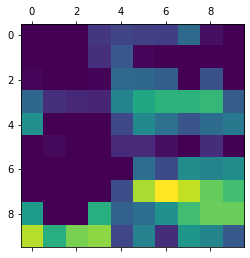

In [104]:
heatmap = heatmap.squeeze()[sample_ind]

# draw the heatmap
plt.matshow(heatmap)

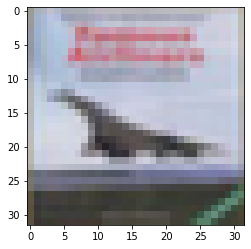

In [105]:
image = img[sample_ind]
imshow(image)

(32, 32, 3)


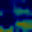

In [106]:
import cv2
from google.colab.patches import cv2_imshow

image = image / 2 + 0.5     # unnormalize
img_np = np.transpose(image.numpy(), (1, 2, 0))
print(img_np.shape)
img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

heatmap_np = heatmap.numpy()
heatmap = cv2.resize(heatmap.numpy(), (32, 32))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img_cv2
cv2_imshow(superimposed_img)

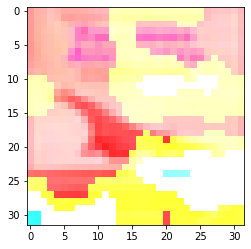

In [107]:
# scaled_superimposed_img = superimposed_img / superimposed_img.max() # scale to [0,1]
plt.imshow(superimposed_img)
plt.show()

# Implementing GradCAM
Using this library: https://github.com/jacobgil/pytorch-grad-cam

In [ ]:
!pip install grad-cam

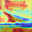

In [108]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model = convnet
target_layers = nn.Sequential(
                model.convnet.conv1,
                model.convnet.relu1,
                model.convnet.pool1,
                model.convnet.conv2,
                model.convnet.relu2
                )
input_tensor = img
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# We have to specify the target we want to generate the Class Activation Maps for.
# If targets is None, the highest scoring category will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = [ClassifierOutputTarget()]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=None)
# grayscale_cam = cam(input_tensor=input_tensor, targets=None, aug_smooth=True, eigen_smooth=True)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[sample_ind]
visualization = show_cam_on_image(img_cv2, grayscale_cam, use_rgb=True)
cv2_imshow(visualization)

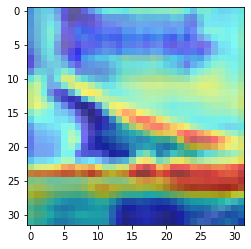

In [109]:
visualization = visualization / visualization.max() # scale to [0,1]
plt.imshow(visualization)
plt.show()